In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.io.shapereader as shapereader
import shapely.affinity as shp
import numpy as np 
import matplotlib.ticker as mticker

In [2]:
shapename = 'admin_1_states_provinces_lakes_shp' # specified at http://naturalearthdata.com 
states_shp = shapereader.natural_earth(resolution='110m',
                                       category='cultural',
                                       name=shapename)
reader = shapereader.Reader(states_shp)
countries = reader.records() 

In [3]:
df = pd.read_csv("./data/final_loc_data.csv")
pd.to_datetime(df.time)
df.head() 

,time,site,precip,rh,solrad,temp,lat,lon,city,state
0,1961-01-01,3103,NaN,NaN,NaN,NaN,35.08,111.4,FLAGSTAFF,AZ
1,1961-02-01,3103,NaN,NaN,NaN,NaN,35.08,111.4,FLAGSTAFF,AZ
2,1961-03-01,3103,NaN,NaN,NaN,NaN,35.08,111.4,FLAGSTAFF,AZ
3,1961-04-01,3103,NaN,NaN,NaN,NaN,35.08,111.4,FLAGSTAFF,AZ
4,1961-05-01,3103,NaN,NaN,NaN,NaN,35.08,111.4,FLAGSTAFF,AZ


In [ ]:
# some plot parameters 
facecolor = 'w'
df2 = df.copy()  

# original location: 
ax.set_extent([-160, -75, 21, 70], ccrs.Geodetic())  
AKratio = 1
HIratio = 1
AKtrans = [0,0]
HItrans = [0,0]  

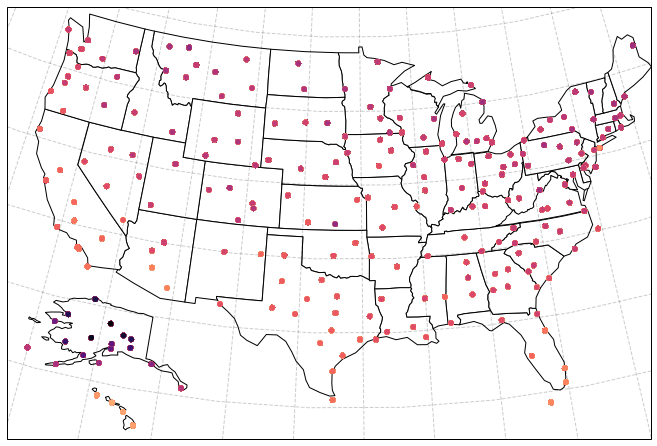

In [5]:
fig = plt.figure(figsize=(16, 6))
ax = fig.add_axes([0, 0, 1, 1], projection=ccrs.LambertConformal())  

# if uncommented, moves Alaska and HawaII closer to the mainland
ax.set_extent([-120, -75, 21, 50], ccrs.Geodetic())    
AKratio = 0.3;  # scales Alaska 
HIratio = 0.7 # scales Hawai 
AKtrans = [38,-36] # moves Alaska south and east 
HItrans = [44,3] # moves Hawaii east and north 

def transform_state( geom, data_frame, trans_x, trans_y, scaling_factor):
        dataFrame_out = data_frame.copy() 
        geoTrans = shp.translate( geom, trans_x, trans_y)  
        centroid = geoTrans.centroid.coords[0]
        geoTransScale = shp.scale( geoTrans, xfact=scaling_factor, yfact=scaling_factor, origin=centroid)
        ax.add_geometries( geoTransScale, ccrs.PlateCarree(), facecolor=facecolor, edgecolor='k')   
        
        dataFrame_out.loc[:,'lon'] = ((data_frame.loc[:,'lon']  - trans_x + centroid[0] )*
                                        scaling_factor  - centroid[0]  )
        dataFrame_out.loc[:,'lat'] = ((data_frame.loc[:,'lat']  + trans_y - centroid[1] )*
                                        scaling_factor  + centroid[1]  ) 
        return dataFrame_out
    
for state in shapereader.Reader(states_shp).records():   
    if  state.attributes['name'] =='Alaska':   
        df_AK = transform_state(state.geometry, 
                                df.loc[df['state']=='AK'], 
                                AKtrans[0], AKtrans[1],
                                AKratio)  
        df2.loc[df2['state']=='AK'] = df_AK
    elif  state.attributes['name'] =='Hawaii':   
        df_HI = transform_state(state.geometry, 
                                df.loc[df['state']=='HI'], 
                                HItrans[0], HItrans[1],
                                HIratio)  
        df2.loc[df2['state']=='HI'] = df_HI
    else:  
        ax.add_geometries([state.geometry], ccrs.PlateCarree(),
                      facecolor=facecolor, edgecolor='k')
 
ax.scatter( - df2['lon'], df2['lat'], transform=ccrs.PlateCarree(), 
           c=df2['temp'], s=20, cmap='magma',zorder = 10)
 
gl = ax.gridlines(linewidth=1, color='black', alpha=0.2, linestyle='--')
gl.ylocator = mticker.FixedLocator(np.arange( 0,90,5))
gl.xlocator = mticker.FixedLocator(np.arange(-220,-20,5))   